In [1]:
import sys
sys.path.insert(0, '../../stock_factor_lab/')

# 美股

## import

In [2]:
from get_data import Data
import backtest
from combinations import sim_conditions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from itertools import cycle
from plotly.subplots import make_subplots
from matplotlib import rcParams
rcParams['font.sans-serif'] = ['Microsoft JhengHei']
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates
from datetime import datetime

# from dataframe import CustomDataFrame

import plot_data

In [3]:
# pd.options.display.float_format = '{:.4f}'.format # 禁用科學數字

## 日期設定

In [4]:
START_DATE = '2009-01-01'
END_DATE = '2024-09-30'

## get data

In [5]:
data=Data(market='US')

---

## 畫圖 Function

In [6]:
from matplotlib.ticker import PercentFormatter

def plot_diff_PER_cagr(report_collec, title='CAGR 比較'):
    """
    將策略分為以'PE_8', 'PE_10'和'PE_12'結尾的三個CAGR折線圖，並顯示在同一圖表上

    參數:
    report_collec: 策略報告集合
    title: 圖表標題

    返回: 顯示圖表
    """

    reports = report_collec.reports

    strategies_pe8 = []
    cagr_values_pe8 = []
    strategies_pe10 = []
    cagr_values_pe10 = []
    strategies_pe12 = []
    cagr_values_pe12 = []

    # 獲得每個策略的CAGR，並根據命名進行分類
    for strategy_name, report in reports.items():
        if strategy_name.endswith('本益比<8進場'):
            prefix = strategy_name.replace('_本益比<8進場', '')
            strategies_pe8.append(prefix)
            cagr = report.get_stats()['CAGR'] * 100
            cagr_values_pe8.append(cagr)
        elif strategy_name.endswith('本益比<10進場'):
            prefix = strategy_name.replace('_本益比<10進場', '')
            strategies_pe10.append(prefix)
            cagr = report.get_stats()['CAGR'] * 100
            cagr_values_pe10.append(cagr)
        elif strategy_name.endswith('本益比<12進場'):
            prefix = strategy_name.replace('_本益比<12進場', '')
            strategies_pe12.append(prefix)
            cagr = report.get_stats()['CAGR'] * 100
            cagr_values_pe12.append(cagr)

    # 確保三個列表的長度一致，以保持x軸一致性
    all_prefixes = sorted(list(set(strategies_pe8) | set(strategies_pe10) | set(strategies_pe12)))

    cagr_values_pe8_aligned = [cagr_values_pe8[strategies_pe8.index(prefix)] if prefix in strategies_pe8 else None for prefix in all_prefixes]
    cagr_values_pe10_aligned = [cagr_values_pe10[strategies_pe10.index(prefix)] if prefix in strategies_pe10 else None for prefix in all_prefixes]
    cagr_values_pe12_aligned = [cagr_values_pe12[strategies_pe12.index(prefix)] if prefix in strategies_pe12 else None for prefix in all_prefixes]

    # 繪製同一張圖上的三條線
    plt.figure(figsize=(10, 6))

    plt.plot(all_prefixes, cagr_values_pe8_aligned, marker='o', label='PE_8', color='tab:green')
    plt.plot(all_prefixes, cagr_values_pe10_aligned, marker='o', label='PE_10', color='tab:blue')
    plt.plot(all_prefixes, cagr_values_pe12_aligned, marker='o', label='PE_12', color='tab:orange')

    # 設定圖表標題與軸標籤
    plt.title(title)
    # plt.xlabel('配息率三年至少>多少%')
    plt.ylabel('CAGR (%)')
    plt.gca().yaxis.set_major_formatter(PercentFormatter())

    # 設定 x 軸刻度及旋轉角度
    plt.xticks(rotation=90, ha='right', fontsize=10)

    # 添加網格線和圖例
    plt.grid(True, alpha=0.7, axis='y', linestyle='--')
    plt.legend()

    plt.tight_layout()

    # 顯示圖表
    plt.show()

---

## 資料下載

In [7]:
close = data.get('price:close')

### **盈餘再投資率**

In [8]:
netIncome = data.get('annual_report_fundamentals:netIncome')

# 4 年加總 #
df = netIncome.copy()
# 提取index的月份
df['month'] = df.index.month
# 依據月份分組，對每個月份的每四年進行加總
result = df.groupby('month', group_keys=False).apply(lambda group: group.rolling(4, min_periods=4).sum())
# result

# 刪除用來group的欄位
netprofit_rol = result.drop(columns='month')

In [9]:
# 去除稅後淨利為負 (計算盈再率)
adj_netprofit = netprofit_rol[(netprofit_rol > 0) & (netIncome > 0)]

In [10]:
# 長期投資
longTermInvestments = data.get('annual_report_fundamentals:longTermInvestments')
# 固定資產
propertyPlantEquipmentNet = data.get('annual_report_fundamentals:propertyPlantEquipmentNet')


capex = longTermInvestments + propertyPlantEquipmentNet
# 以月份為單位，所以要減掉 48 個月前的資料 (第四年 - 第0年)
capex_rol = capex.diff(48)


rr = capex_rol / adj_netprofit

In [11]:
# plot_data.numeric_bins(rr.resample("A-MAY").last(), '美股盈再率')

---

### **本益比 (P/E)**

In [12]:
pe = data.get('quarter_report:PE')

In [13]:
eps = data.get('quarter_report:EPS')

In [14]:
eps_rol = eps + eps.shift(3) + eps.shift(6) + eps.shift(9) # 近四季加總
pe_daily = (close / eps_rol)
pe_daily = pe_daily[eps_rol > 0]

### **其他因子**

- ROE (季資料，取第四季)
- 股利支付率 (只有年資料) ＝〈現金股利總額〈元〉／ 股利分配年度之稅後淨利〉x 100
- 董監持股 (沒有每年的資料，缺值採向前補值)
- 上市上櫃滿兩年

In [15]:
roe = data.get('annual_report:ROE')

In [16]:
dpr = data.get('annual_report_fundamentals:dividendPayoutRatio')

In [17]:
income_bf_tax = data.get('annual_report_fundamentals:incomeBeforeTax')

In [18]:
comp_profile = data.get('company_profile')
comp_profile

,company_symbol,name,ipo_date,industry
0,A,"Agilent Technologies, Inc.",1999-11-18,Medical - Diagnostics & Research
1,AA,Alcoa Corporation,2016-11-01,Aluminum
2,AAL,American Airlines Group Inc.,2005-09-27,"Airlines, Airports & Air Services"
3,AAN,"The Aaron's Company, Inc.",2020-11-25,Rental & Leasing Services
4,AAON,"AAON, Inc.",1992-12-16,Construction
...,...,...,...,...
2634,ZUMZ,Zumiez Inc.,2005-05-06,Apparel - Retail
2635,ZUO,"Zuora, Inc.",2018-04-12,Software - Infrastructure
2636,ZWS,Zurn Elkay Water Solutions Corporation,2012-03-29,Industrial - Pollution & Treatment Controls
2637,ZYME,Zymeworks Inc.,2017-04-28,Biotechnology


In [19]:
stock_data = {}

for index, row in comp_profile.iterrows():
    stock_code = row['company_symbol']
    listed_date_ = row['ipo_date']
    end_date = listed_date_ + pd.DateOffset(years=2)
    
    # 創建一個全為 True 的 series
    series = pd.Series(True, index=close.index)
    # 在上市日之前和之後兩年內設置為 False
    series.loc[:end_date] = False
    
    stock_data[stock_code] = series

listed_df = pd.concat(stock_data, axis=1)

---

## 選股條件
- ROE 五年平均 > 15%
- 盈再率 < 40%
- 稅後淨利 > 五億台幣 (7500萬美元)，稅前淨利 > 7500萬美元
- 配息 > 40%
- 上市上櫃滿兩年
- PE < 12買入，>30賣出

### ROE

In [20]:
# ROE 5年平均 > 15%
df = roe.copy()
# 提取index的月份
df['month'] = df.index.month
# 依據月份分組，對每個月份的每5年計算平均
result = df.groupby('month', group_keys=False).apply(lambda group: group.rolling(5, min_periods=5).mean())
# 刪除用來group的欄位
roe_rol = result.drop(columns='month')

In [21]:
roe_cond = (roe_rol > 0.15)[START_DATE:END_DATE]

### 盈再率

In [22]:
rr_cond = (rr < 0.4)[START_DATE:END_DATE]

### 稅後淨利、稅前淨利

In [23]:
# netprofit_cond = (netIncome > 75000000)[START_DATE:END_DATE]

In [24]:
netprofit_cond = (income_bf_tax > 75000000)[START_DATE:END_DATE]

### 配息率

In [25]:
payout_ratio = dpr.copy()
payout_ratio = payout_ratio[(netIncome > 0) & (payout_ratio > 0)]


# 3 年至少 > 40%
df = payout_ratio.copy()
# 提取index的月份
df['month'] = df.index.month
# 依據月份分組，對每個月份的每四年進行加總
result = df.groupby('month', group_keys=False).apply(lambda group: group.rolling(3, min_periods=3).min())
# 刪除用來group的欄位
payout_ratio_rol = result.drop(columns='month')

In [26]:
payout_cond = (payout_ratio_rol >= 0.4)[START_DATE:END_DATE]

### 本益比

#### 每季

In [27]:
pe_cond_entry_Q = (pe < 12)[START_DATE:END_DATE]
pe_cond_exit_Q = (pe > 30)[START_DATE:END_DATE]

#### 每日

In [28]:
daily_pe_resample = pe_daily.resample('M').last()[START_DATE:END_DATE]

pe_cond_entry = (daily_pe_resample < 12)
pe_cond_exit =  (daily_pe_resample > 30)

### 上市滿兩年

In [29]:
listed_cond = listed_df.resample('M').last()

---

## 所有條件不含本益比進出場

In [30]:
orig_cond = (rr < 0.8) & roe_cond & netprofit_cond & payout_cond & listed_cond
orig_cond_opt = rr_cond & roe_cond & netprofit_cond & payout_cond & listed_cond

### 盈再率 < 40%

In [31]:
rep_orig_opt = backtest.sim(orig_cond_opt, resample='M', data=data)
rep_orig_opt.get_stats()

{'CAGR': 0.16540875206719674,
 'daily_sharpe': 31.07,
 'max_drawdown': -0.3825969026381447,
 'avg_drawdown': -0.02913321098616934,
 'win_ratio': 0.7351598173515982,
 'ytd': 0.12629318058762307}

### 不看配息率

In [32]:
nodpr_cond = (rr < 0.8) & roe_cond & netprofit_cond & listed_cond
nodpr_cond_opt = rr_cond & roe_cond & netprofit_cond & listed_cond

In [33]:
noDPRrep_opt = backtest.sim(nodpr_cond_opt, resample='M', data=data)
noDPRrep_opt.get_stats()

{'CAGR': 0.1859541270985383,
 'daily_sharpe': 28.0,
 'max_drawdown': -0.3933434017522528,
 'avg_drawdown': -0.04034409121952658,
 'win_ratio': 0.6962616822429907,
 'ytd': 0.11597858574437447}

## 所有條件包含本益比進出場

### 盈再率 < 40%

In [34]:
opt_orig_pe = (orig_cond_opt & pe_cond_entry).hold_until((~orig_cond_opt) | pe_cond_exit)

In [35]:
opt_rep_pe = backtest.sim(opt_orig_pe, resample='M', data=data)
opt_rep_pe.get_stats()

{'CAGR': 0.16283132519699461,
 'daily_sharpe': 30.68,
 'max_drawdown': -0.39350976771098034,
 'avg_drawdown': -0.03583305231329648,
 'win_ratio': 0.7261146496815286,
 'ytd': 0.11877994546373749}

In [36]:
opt_rep_pe_pos, opt_rep_pe_neg = opt_rep_pe.calc_returns_contrib()

In [37]:
# opt_rep_pe.trades.to_csv(f'./performance_file/US/00美股_原始條件_交易明細_{START_DATE}_{END_DATE}.csv', encoding='cp950')

### 不包含配息率

### 盈再率 < 40%

In [38]:
opt_noDPR_pe = (nodpr_cond_opt & pe_cond_entry).hold_until((~nodpr_cond_opt) | pe_cond_exit)

In [39]:
rep_opt_noDPR_pe = backtest.sim(opt_noDPR_pe, resample='M', data=data)
rep_opt_noDPR_pe.get_stats()

{'CAGR': 0.18472889036319806,
 'daily_sharpe': 28.23,
 'max_drawdown': -0.4258971187190842,
 'avg_drawdown': -0.041635349510193674,
 'win_ratio': 0.7303851640513552,
 'ytd': 0.08904376808110914}

---

## 上面的入選股數比較

In [40]:
daily_pe_lower = daily_pe_resample < 10

In [68]:
overall_conds = {}

# overall_conds['所有條件_盈再率<80_本益比'] = (orig_cond & pe_cond_entry).hold_until((~orig_cond) | pe_cond_exit)
# overall_conds['所有條件_盈再率<80_本益比_ROE出場條件'] = (orig_cond & pe_cond_entry).hold_until((~orig_cond) | pe_cond_exit | (roe < 0.15))
overall_conds['所有條件_盈再率<40_本益比_ROE出場條件'] = (orig_cond_opt & pe_cond_entry).hold_until((~orig_cond_opt) | pe_cond_exit | (roe < 0.15))
overall_conds['所有條件_盈再率<80_無本益比'] = orig_cond.copy()
overall_conds['所有條件_盈再率<40_無本益比'] = orig_cond_opt.copy()
overall_conds['所有條件_盈再率<40_本益比'] = opt_orig_pe.copy()
overall_conds['去掉配息盈再率<40_無本益比'] = nodpr_cond_opt.copy()
overall_conds['去掉配息_盈再率<40_本益比'] = opt_noDPR_pe.copy()
overall_conds['所有條件_盈再率<40_本益比<10'] = (orig_cond_opt & daily_pe_lower).hold_until((~orig_cond_opt) | pe_cond_exit)
# overall_conds['只看盈再率<40'] = rr_cond.copy()
# overall_conds['只看ROE五年平均>15'] = roe_cond.copy()



overall_conds_collecs = sim_conditions(overall_conds, resample='M', data=data)
overall_conds_collecs.selected_stock_count_analysis()

Backtesting progress: 100%|██████████| 7/7 [00:38<00:00,  5.53s/condition]


,CAGR,MDD,入選股數平均,中位數,25%,75%,Min,Max
Strategy,,,,,,,,
去掉配息盈再率<40_無本益比,0.185954,-0.393343,279.204545,280.0,228.00,322.00,208.0,399.0
去掉配息_盈再率<40_本益比,0.184729,-0.425897,154.310606,158.0,151.00,166.00,83.0,210.0
所有條件_盈再率<80_無本益比,0.167718,-0.385299,58.424242,67.0,41.00,76.00,30.0,84.0
所有條件_盈再率<40_本益比_ROE出場條件,0.165584,-0.378914,22.075758,22.0,20.00,25.00,15.0,31.0
所有條件_盈再率<40_無本益比,0.165409,-0.382597,52.196970,57.0,37.00,65.25,27.0,77.0
所有條件_盈再率<40_本益比<10,0.164904,-0.375034,18.803030,19.0,15.75,21.00,10.0,28.0
所有條件_盈再率<40_本益比,0.162831,-0.393510,25.689394,26.0,23.00,29.00,15.0,37.0


In [69]:
overall_conds_collecs.holding_period_analysis()

,CAGR,MDD,持有期間平均,25%,中位數,75%,最大值,最小值
Strategy,,,,,,,,
去掉配息盈再率<40_無本益比,0.185954,-0.393343,1267.782123,365.0,731.0,1796.00,5701,9
去掉配息_盈再率<40_本益比,0.184729,-0.425897,1019.553364,336.0,556.0,1365.00,5701,9
所有條件_盈再率<80_無本益比,0.167718,-0.385299,1101.707641,365.0,730.0,1460.00,5701,9
所有條件_盈再率<40_本益比_ROE出場條件,0.165584,-0.378914,868.613793,303.0,395.0,1096.00,5701,28
所有條件_盈再率<40_無本益比,0.165409,-0.382597,1035.541958,364.0,728.5,1453.75,5701,9
所有條件_盈再率<40_本益比<10,0.164904,-0.375034,837.437500,244.0,366.0,1096.25,5701,28
所有條件_盈再率<40_本益比,0.162831,-0.393510,844.606936,304.0,374.0,1097.00,5701,28


In [74]:
overall_conds_collecs.reports['所有條件_盈再率<40_無本益比'].trades.sort_values('period')

,stock_id,entry_date,exit_date,entry_sig_date,exit_sig_date,position,period,return,mae,gmfe,bmfe,mdd,pdays
trade_index,,,,,,,,,,,,,
244,ETD,2024-10-01,NaT,2024-09-30,NaT,0.014925,8,-0.081719,-0.071719,0.000000,0.000000,-0.071719,0.0
204,HNI,2023-04-03,2023-05-01,2023-03-31,2023-04-28,0.016393,19,-0.084963,-0.104948,0.000000,0.000000,-0.104948,0.0
148,JWN,2020-05-01,2020-06-01,2020-04-30,2020-05-29,0.014925,20,-0.070683,-0.144753,0.112516,0.020860,-0.178977,4.0
172,HNI,2021-04-01,2021-05-03,2021-03-31,2021-04-30,0.018182,21,0.076015,0.000000,0.086015,0.000000,-0.019486,21.0
46,DBI,2014-05-01,2014-06-02,2014-04-30,2014-05-30,0.023810,21,-0.259507,-0.297596,0.032322,0.032322,-0.319588,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,ADP,2009-10-01,NaT,2009-09-30,NaT,0.032258,3782,11.024815,-0.004614,11.070889,0.000000,-0.394496,3778.0
218,SYY,2009-03-02,2024-10-01,2009-02-27,2024-09-30,0.031250,3923,4.889160,-0.066463,5.414820,0.016043,-0.634003,3916.0
272,PAYX,2009-03-02,NaT,2009-02-27,NaT,0.031250,3931,10.379207,-0.013900,10.511856,0.038430,-0.441514,3929.0


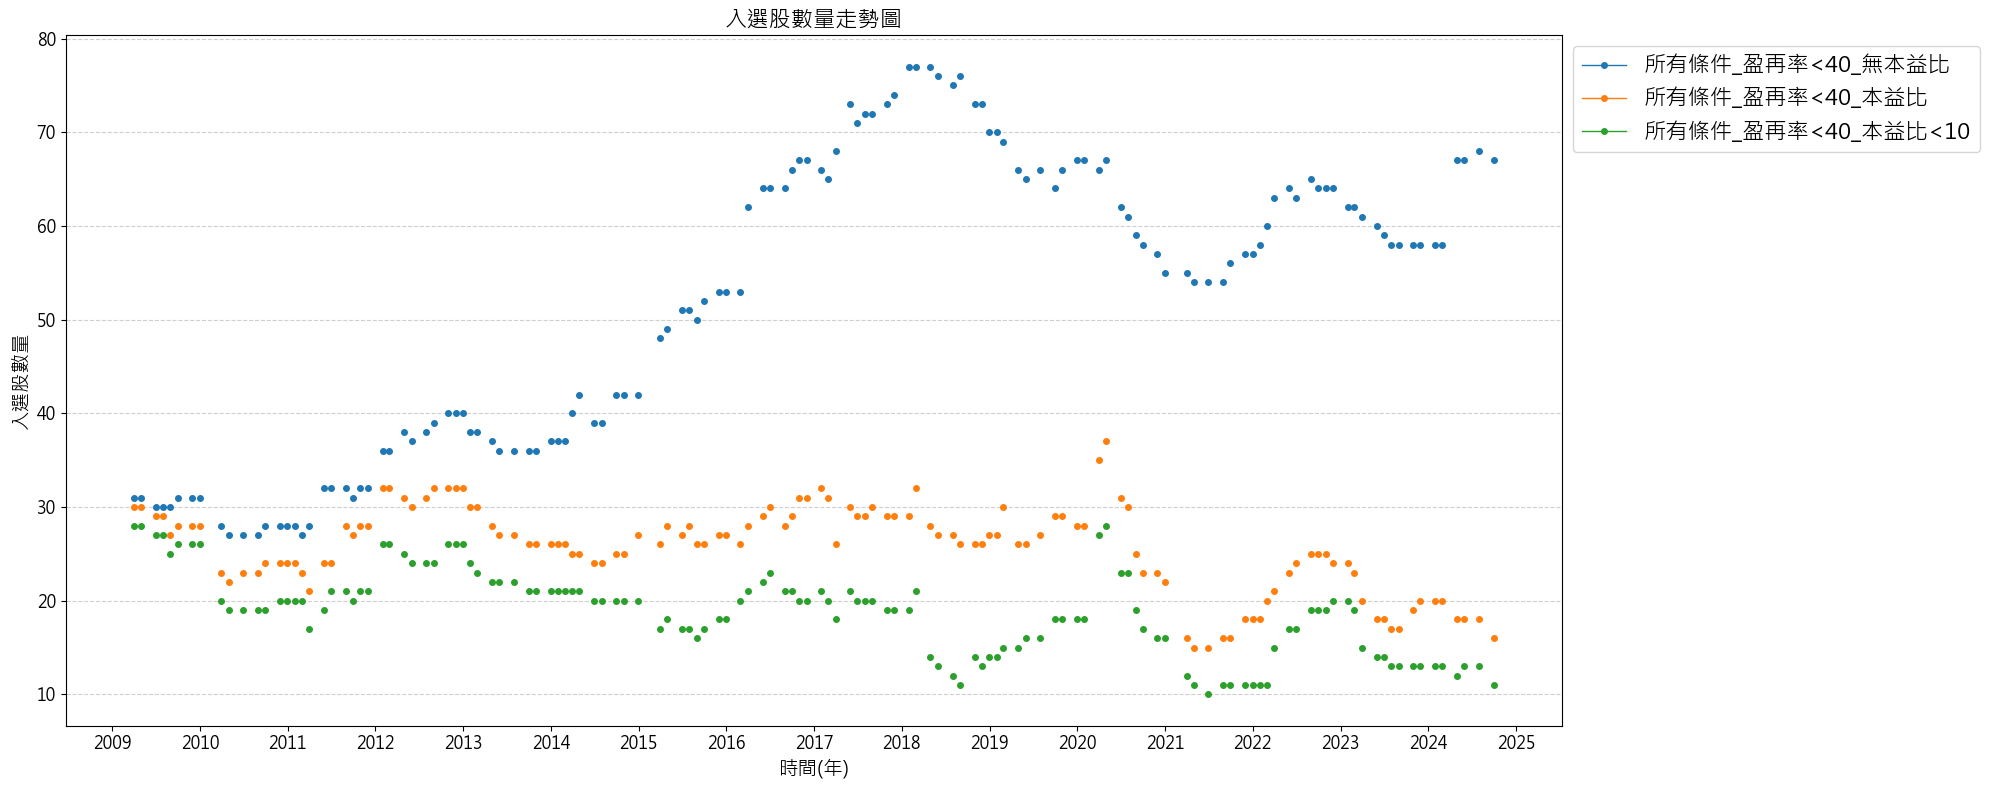

In [42]:
overall_conds_collecs.plot_reps_stock_counts(['所有條件_盈再率<40_無本益比', '所有條件_盈再率<40_本益比', '所有條件_盈再率<40_本益比<10'])

In [43]:
# overall_conds_collecs.selected_stock_count_analysis().to_csv(f'./performance_file/US/00美股_原始條件比較_{START_DATE}_{END_DATE}.csv', encoding='cp950')

---

---

## 本益比更低、當年度ROE<15%出場

### 有配息率

In [44]:
pe_opts = {}

for i in range(8, 13, 2):
    # pe_opts[f'原始條件_盈再率80_PE_{i}'] = (orig_cond & (daily_pe_resample < i)).hold_until((~orig_cond) | pe_cond_exit)
    pe_opts[f'盈再率<40+PE<{i}進場'] = (orig_cond_opt & (daily_pe_resample < i)).hold_until((~orig_cond_opt) | pe_cond_exit)

    # pe_opts[f'原始條件_盈再率80_PE_{i}_ROE<15出場'] = (orig_cond & (daily_pe_resample < i)).hold_until((~orig_cond) | pe_cond_exit | (roe < 0.15))
    pe_opts[f'盈再率<40+PE<{i}進場+ROE<15出場條件'] = (orig_cond_opt & (daily_pe_resample < i)).hold_until((~orig_cond_opt) | pe_cond_exit | (roe < 0.15))



pe_opts_collecs = sim_conditions(pe_opts, resample='M', data=data)
pe_opts_collecs.selected_stock_count_analysis()

Backtesting progress: 100%|██████████| 6/6 [00:03<00:00,  1.76condition/s]


,CAGR,MDD,入選股數平均,中位數,25%,75%,Min,Max
Strategy,,,,,,,,
盈再率<40+PE<8進場+ROE<15出場條件,0.179680,-0.357332,10.946970,10.0,8.00,13.0,4.0,21.0
盈再率<40+PE<8進場,0.174824,-0.357332,12.916667,13.0,9.00,16.0,4.0,26.0
盈再率<40+PE<10進場+ROE<15出場條件,0.169262,-0.350065,16.136364,16.0,13.00,18.0,10.0,26.0
盈再率<40+PE<12進場+ROE<15出場條件,0.165584,-0.378914,22.075758,22.0,20.00,25.0,15.0,31.0
盈再率<40+PE<10進場,0.164904,-0.375034,18.803030,19.0,15.75,21.0,10.0,28.0
盈再率<40+PE<12進場,0.162831,-0.393510,25.689394,26.0,23.00,29.0,15.0,37.0


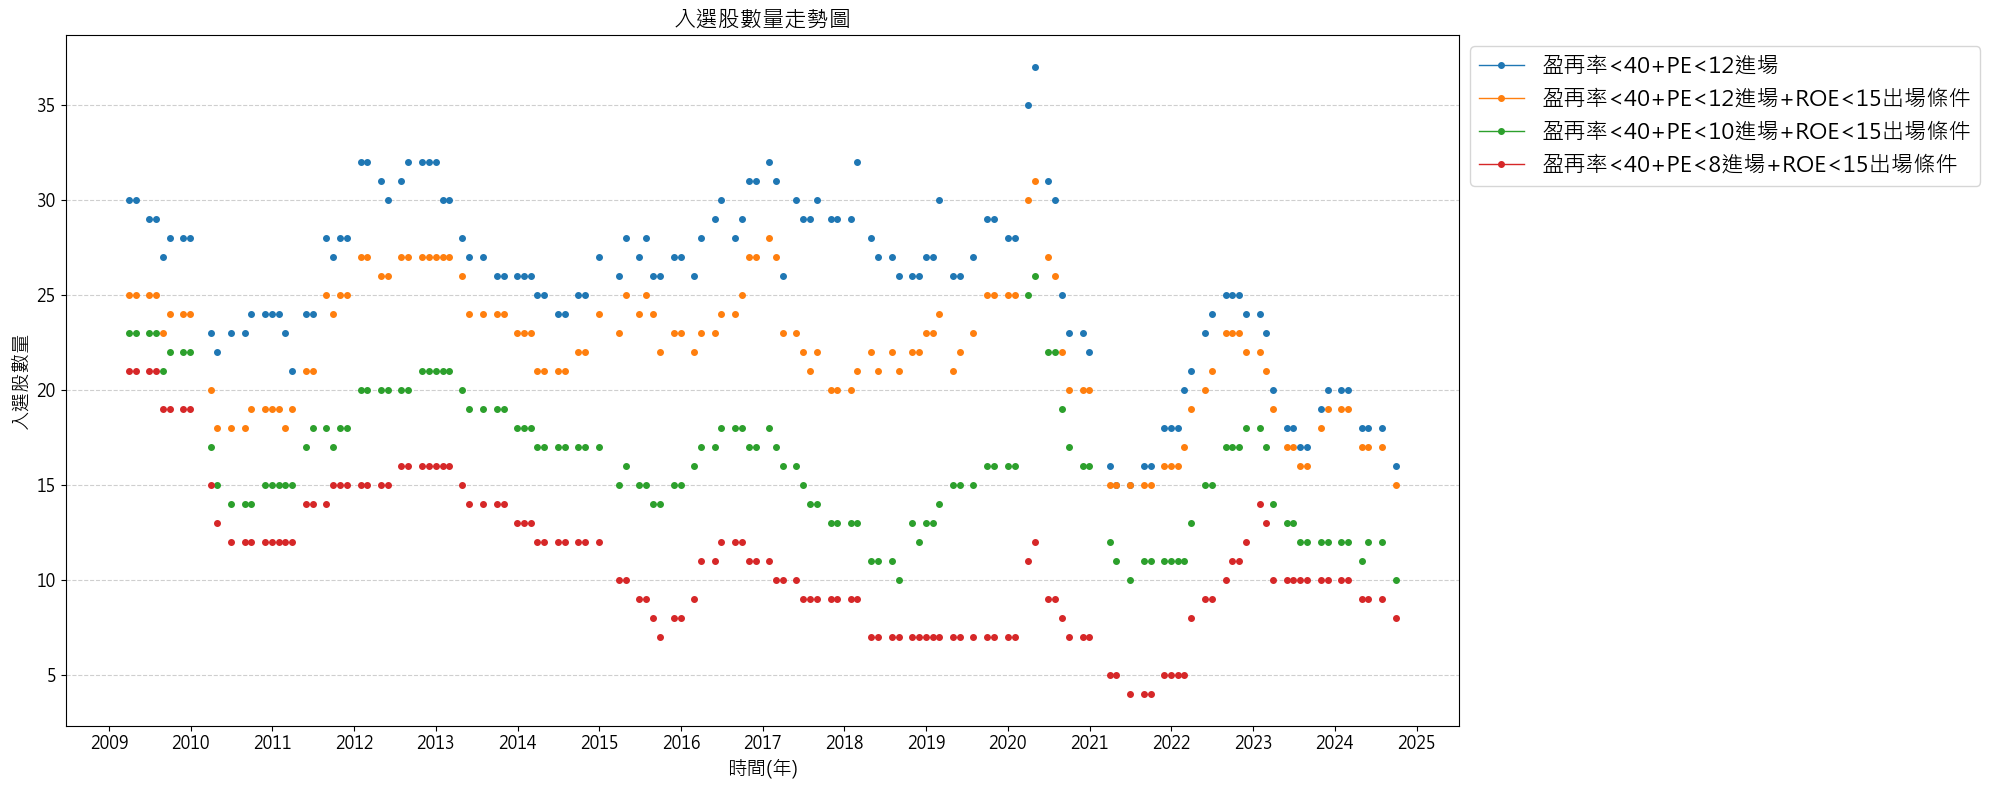

In [45]:
pe_opts_collecs.plot_reps_stock_counts(['盈再率<40+PE<12進場', '盈再率<40+PE<12進場+ROE<15出場條件', '盈再率<40+PE<10進場+ROE<15出場條件', '盈再率<40+PE<8進場+ROE<15出場條件'])

In [46]:
# pe_opts_collecs.selected_stock_count_analysis().to_csv(f'./performance_file/US/01美股_原始條件_盈再率小於40_本益比小於N進場_ROE出場條件_{START_DATE}_{END_DATE}.csv', encoding='cp950')

### 無配息率

In [47]:
# pe_opts_nodpr = {}

# for i in range(8, 13, 2):
#     # pe_opts_nodpr[f'去掉配息_盈再率80_PE_{i}'] = (nodpr_cond & (daily_pe_resample < i)).hold_until((~nodpr_cond) | pe_cond_exit)
#     pe_opts_nodpr[f'去掉配息_盈再率40_PE_{i}'] = (nodpr_cond_opt & (daily_pe_resample < i)).hold_until((~nodpr_cond_opt) | pe_cond_exit)

#     # pe_opts_nodpr[f'去掉配息_盈再率80_PE_{i}_ROE<15出場'] = (nodpr_cond & (daily_pe_resample < i)).hold_until((~nodpr_cond) | (roe < 0.15))
#     pe_opts_nodpr[f'去掉配息_盈再率40_PE_{i}_ROE<15出場'] = (nodpr_cond_opt & (daily_pe_resample < i)).hold_until((~nodpr_cond_opt) | (roe < 0.15))

# pe_opts_nodpr_combs = sim_conditions(pe_opts_nodpr, resample='M', data=data)
# pe_opts_nodpr_combs.selected_stock_count_analysis()

In [48]:
# pe_opts_nodpr_combs.selected_stock_count_analysis().to_csv(f'./performance_file/US/02美股_無配息_盈再率小於40_本益比小於N進場_ROE出場條件_{START_DATE}_{END_DATE}.csv', encoding='cp950')

---

## ROE 參數最佳化

### 有配息率

In [49]:
roe_opts = {}
roe_opt_base = rr_cond & netprofit_cond & payout_cond & listed_cond

# for n in range(3, 6):
for i in range(15, 36, 5):
    for j in range(8, 13, 2):
        # ROE N年平均 > 10%、15%、20%、25%、30%
        df = roe.copy()
        df['month'] = df.index.month
        result = df.groupby('month', group_keys=False).apply(lambda group: group.rolling(5, min_periods=5).mean())
        roe_rol_opt = result.drop(columns='month')

        roe_cond_opt = (roe_rol_opt > (i/100))[START_DATE:END_DATE]
        roe_opt_all = roe_opt_base & roe_cond_opt

        pe_opt_entry_cond = daily_pe_resample < j


        roe_opts[f'ROE_5y_{i}+本益比<{j}進場'] = (roe_opt_all & pe_opt_entry_cond).hold_until((~roe_opt_all) | pe_cond_exit)

        
        roe_opts[f'ROE_5y_{i}_本益比<{j}進場_ROE出場條件'] = (roe_opt_all & pe_opt_entry_cond).hold_until((~roe_opt_all) | pe_cond_exit | (roe < 0.15))




roe_opt_combs = sim_conditions(roe_opts, resample='M', data=data)
roe_opt_combs.selected_stock_count_analysis()

Backtesting progress: 100%|██████████| 30/30 [00:15<00:00,  1.99condition/s]


,CAGR,MDD,入選股數平均,中位數,25%,75%,Min,Max
Strategy,,,,,,,,
ROE_5y_15_本益比<8進場_ROE出場條件,0.179680,-0.357332,10.946970,10.0,8.00,13.00,4.0,21.0
ROE_5y_20_本益比<8進場_ROE出場條件,0.178957,-0.395002,8.795455,9.0,7.00,11.00,4.0,13.0
ROE_5y_25_本益比<8進場_ROE出場條件,0.174982,-0.506585,6.068182,6.0,5.00,7.00,3.0,9.0
ROE_5y_15+本益比<8進場,0.174824,-0.357332,12.916667,13.0,9.00,16.00,4.0,26.0
ROE_5y_20+本益比<8進場,0.170845,-0.395002,9.522727,10.0,7.75,12.00,4.0,15.0
ROE_5y_15_本益比<10進場_ROE出場條件,0.169262,-0.350065,16.136364,16.0,13.00,18.00,10.0,26.0
ROE_5y_25_本益比<10進場_ROE出場條件,0.168710,-0.373310,9.310606,9.0,8.00,10.00,6.0,18.0
ROE_5y_35_本益比<12進場_ROE出場條件,0.167292,-0.352079,6.507576,7.0,5.00,8.00,3.0,15.0
ROE_5y_30_本益比<10進場_ROE出場條件,0.166584,-0.373310,7.522727,7.0,6.00,8.00,5.0,15.0


In [50]:
# roe_opt_combs.selected_stock_count_analysis().to_csv(f'./performance_file/US/03美股_原始條件_ROE五年平均大於N_本益比小於N進場_有無ROE出場條件_{START_DATE}_{END_DATE}.csv', encoding='cp950')

### 無配息率

In [51]:
# roe_opts_nodpr = {}
# roe_opt_base_nodpr = rr_cond & netprofit_cond & listed_cond

# # for n in range(3, 6):
# for i in range(15, 71, 5):
#     for j in range(8, 13, 2): # 本益比 < 8, 10, 12 進場
#         # ROE N年平均 > 10%、15%、20%、25%、30%
#         df = roe.copy()
#         df['month'] = df.index.month
#         result = df.groupby('month', group_keys=False).apply(lambda group: group.rolling(5, min_periods=5).mean())
#         roe_rol_opt = result.drop(columns='month')

#         roe_cond_opt = (roe_rol_opt > (i/100))[START_DATE:END_DATE]
#         roe_nodpr_opt_all = roe_opt_base_nodpr & roe_cond_opt

#         pe_opt_entry_cond = daily_pe_resample < j

#         # roe_opts_nodpr[f'ROE_5y_{i}+PE<{j}進場'] = (roe_nodpr_opt_all & pe_opt_entry_cond).hold_until((~roe_nodpr_opt_all) | pe_cond_exit)

#         roe_opts_nodpr[f'ROE_5y_{i}_本益比<{j}進場'] = (roe_nodpr_opt_all & pe_opt_entry_cond).hold_until((~roe_nodpr_opt_all) | pe_cond_exit | (roe < 0.15))




# roe_opt_combs_nodpr = sim_conditions(roe_opts_nodpr, resample='M', data=data)
# # roe_opt_combs_nodpr.selected_stock_count_analysis()

In [52]:
# roe_opt_combs_nodpr_df = roe_opt_combs_nodpr.selected_stock_count_analysis()
# roe_opt_combs_nodpr_df[(roe_opt_combs_nodpr_df.loc[:, 'Min']>0) & (roe_opt_combs_nodpr_df.loc[:, 'Max']<=25)]

In [53]:
# roe_opt_combs_nodpr.selected_stock_count_analysis().to_csv(f'./performance_file/US/04美股_無配息率_ROE五年平均大於N_本益比小於N進場_ROE出場條件_{START_DATE}_{END_DATE}.csv', encoding='cp950')

In [54]:
# plot_diff_PER_cagr(roe_opt_combs_nodpr, title="ROE參數最佳化 CAGR (無配息率條件)")

---

## 盈餘再投資率、本益比條件設更小

### 有配息率

In [55]:
rr_opts = {}
rr_opt_base = roe_cond & netprofit_cond & payout_cond & listed_cond

for i in [0, 0.2, 0.4, 0.6, 0.8]: # 盈再率
    for n in range(8, 13, 2): # 本益比
        rr_cond_opt = (rr < i)[START_DATE:END_DATE]
        rr_opt_all = rr_opt_base & rr_cond_opt
        pe_opt_cond = (daily_pe_resample < n)

        rr_opts[f'盈再率<{i}_本益比<{n}進場'] = (rr_opt_all & pe_opt_cond).hold_until((~rr_opt_all) | pe_cond_exit)
        # rr_opts[f'盈再率<{i}_本益比<{n}進場_ROE出場條件'] = (rr_opt_all & pe_opt_cond).hold_until((~rr_opt_all) | pe_cond_exit | (roe < 0.15))

        

# rr_opts['盈再率>0.8_本益比<12進場'] = (((rr > 0.8) & rr_opt_base) & pe_cond_entry).hold_until((~((rr > 0.8) & rr_opt_base)) | pe_cond_exit)



rr_opt_combs = sim_conditions(rr_opts, resample='M', data=data)
rr_opt_combs.selected_stock_count_analysis()

Backtesting progress: 100%|██████████| 15/15 [00:09<00:00,  1.51condition/s]


,CAGR,MDD,入選股數平均,中位數,25%,75%,Min,Max
Strategy,,,,,,,,
盈再率<0.4_本益比<8進場,0.174824,-0.357332,12.916667,13.0,9.00,16.0,4.0,26.0
盈再率<0.8_本益比<8進場,0.172793,-0.408089,14.696970,14.5,11.00,17.0,8.0,27.0
盈再率<0.2_本益比<12進場,0.172472,-0.404734,19.651515,20.0,18.00,23.0,9.0,28.0
盈再率<0.2_本益比<10進場,0.171255,-0.391227,13.916667,15.0,9.00,17.0,6.0,25.0
盈再率<0.6_本益比<8進場,0.171155,-0.388459,14.424242,14.5,11.00,17.0,7.0,27.0
盈再率<0.2_本益比<8進場,0.168761,-0.447022,9.060606,10.0,5.00,12.0,1.0,24.0
盈再率<0.8_本益比<10進場,0.165997,-0.393940,21.378788,21.0,18.00,24.0,13.0,36.0
盈再率<0.4_本益比<10進場,0.164904,-0.375034,18.803030,19.0,15.75,21.0,10.0,28.0
盈再率<0.8_本益比<12進場,0.164627,-0.406829,28.393939,29.0,26.00,31.0,18.0,46.0


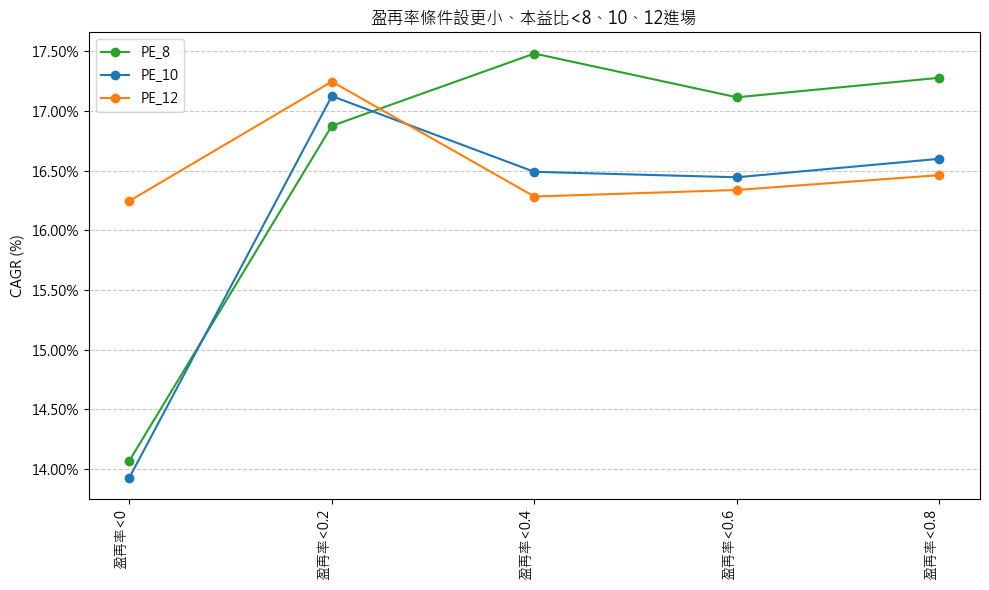

In [56]:
plot_diff_PER_cagr(rr_opt_combs, title='盈再率條件設更小、本益比<8、10、12進場')

### 無配息率

In [57]:
# rr_opts_nodpr = {}
# rr_opt_base_nodpr = roe_cond & netprofit_cond & listed_cond

# for i in [0, 0.2, 0.4, 0.6, 0.8]:
#     for n in range(8, 13, 2):
#         rr_cond_opt = (rr < i)[START_DATE:END_DATE]
#         rr_nodpr_opt_all = rr_opt_base_nodpr & rr_cond_opt
#         nodpr_pe_cond = (daily_pe_resample < n)

#         rr_opts_nodpr[f'盈再率<{i}_本益比<{n}進場'] = (rr_nodpr_opt_all & nodpr_pe_cond).hold_until((~rr_nodpr_opt_all) | pe_cond_exit)



# rr_opt_combs_nodpr = sim_conditions(rr_opts_nodpr, resample='M', data=data)
# rr_opt_combs_nodpr.selected_stock_count_analysis()

In [58]:
# rr_opt_combs_nodpr.selected_stock_count_analysis().to_csv(f'./performance_file/US/05美股_原始條件_盈再率小於N_本益比小於N進場_{START_DATE}_{END_DATE}.csv', encoding='cp950')

## 盈再率 + 配息率

In [59]:
rr_dpr_opts = {}
rr_dpr_opt_base = roe_cond & netprofit_cond & listed_cond

for i in [0, 0.2, 0.4]: #, 0.6, 0.8]: # 盈再率
    for n in range(8, 13, 2): # 本益比
        for j in range(5, 46, 5): # 配息率
            
            payout_df = payout_ratio.copy()
            payout_df['month'] = payout_df.index.month
            payout_result = payout_df.groupby('month', group_keys=False).apply(lambda group: group.rolling(3, min_periods=3).min())
            payout_ratio_rol = payout_result.drop(columns='month')
            payout_cond_opt = (payout_ratio_rol >= (j/100))[START_DATE:END_DATE]
            

            rr_cond_opt = (rr < i)[START_DATE:END_DATE]

            rr_nodpr_opt_all = rr_dpr_opt_base & rr_cond_opt & payout_cond_opt
            nodpr_pe_cond = (daily_pe_resample < n)

            rr_dpr_opts[f'盈再率<{i}_配息率{j}_本益比<{n}進場'] = (rr_nodpr_opt_all & nodpr_pe_cond).hold_until((~rr_nodpr_opt_all) | pe_cond_exit)



rr_dpr_opts_combs_nodpr = sim_conditions(rr_dpr_opts, resample='M', data=data)
rr_dpr_opts_combs_nodpr.selected_stock_count_analysis()

Backtesting progress: 100%|██████████| 81/81 [01:20<00:00,  1.01condition/s]


,CAGR,MDD,入選股數平均,中位數,25%,75%,Min,Max
Strategy,,,,,,,,
盈再率<0.2_配息率5_本益比<12進場,0.184101,-0.428766,83.333333,87.0,72.00,95.00,40.0,116.0
盈再率<0.2_配息率10_本益比<12進場,0.181974,-0.419669,77.219697,83.0,60.75,90.00,36.0,105.0
盈再率<0.2_配息率5_本益比<10進場,0.177984,-0.452338,66.166667,67.0,53.00,78.50,29.0,106.0
盈再率<0.2_配息率5_本益比<8進場,0.177513,-0.473360,48.719697,49.0,39.00,58.25,20.0,89.0
盈再率<0.2_配息率15_本益比<12進場,0.177023,-0.417834,67.901515,76.0,50.00,82.00,28.0,92.0
...,...,...,...,...,...,...,...,...
盈再率<0_配息率45_本益比<12進場,0.123482,-0.423936,5.613636,5.0,3.75,7.25,2.0,13.0
盈再率<0_配息率25_本益比<8進場,0.123159,-0.473284,8.212121,8.0,4.75,11.00,1.0,20.0
盈再率<0_配息率25_本益比<10進場,0.120656,-0.441131,11.696970,12.0,7.00,15.00,3.0,25.0


In [60]:
# rr_dpr_opts_combs_nodpr.selected_stock_count_analysis().to_csv(f'./performance_file/US/06美股_無配息條件_盈再率小於N_配息率三年至少大於N_本益比小於N進場_{START_DATE}_{END_DATE}.csv', encoding='cp950')

In [61]:
# rr_dpr_opts_combs_nodpr_df = rr_dpr_opts_combs_nodpr.selected_stock_count_analysis()
# rr_dpr_opts_combs_nodpr_df[(rr_dpr_opts_combs_nodpr_df.loc[:, 'Min']>0)].iloc[:21, :]

---

## ROE5年平均 + 配息率

In [63]:
roe_dpr_opts = {}
roe_dpr_opts_base = netprofit_cond & listed_cond


# for k in [0.4, 0.8]: # 盈再率
k=0.4

for n in range(8, 13, 2): # 本益比
    for i in range(15, 31, 5): # ROE
        for j in range(0, 51, 5): # 配息率
            # 3 年至少 > 0-40%
            payout_df = payout_ratio.copy()
            payout_df['month'] = payout_df.index.month
            payout_result = payout_df.groupby('month', group_keys=False).apply(lambda group: group.rolling(3, min_periods=3).min())
            payout_ratio_rol = payout_result.drop(columns='month')
            payout_cond_opt = (payout_ratio_rol >= (j/100))[START_DATE:END_DATE]


            # ROE 5年平均 > 10%、15%、20%、25%、30%
            roe_df = roe.copy()
            roe_df['month'] = roe_df.index.month
            roe_result = roe_df.groupby('month', group_keys=False).apply(lambda group: group.rolling(5, min_periods=5).mean())
            roe_rol_opt = roe_result.drop(columns='month')
            roe_cond_opt = (roe_rol_opt > (i/100))[START_DATE:END_DATE]

            rr_opt_conds = (rr < 0.4)[START_DATE:END_DATE]


            roe_dpr_opt_all = rr_opt_conds & roe_dpr_opts_base & roe_cond_opt & payout_cond_opt

            pe_opt_entry_cond = daily_pe_resample < n

            roe_dpr_opts[f'ROE_5y_{i}+盈再率<{k}+配息率三年至少{j}%+PE<{n}進場'] = (roe_dpr_opt_all & pe_opt_entry_cond).hold_until((~roe_dpr_opt_all) | pe_cond_exit)

            roe_dpr_opts[f'ROE_5y_{i}+盈再率<{k}+配息率三年至少{j}%+PE<{n}進場+ROE<15出場條件'] = (roe_dpr_opt_all & pe_opt_entry_cond).hold_until((~roe_dpr_opt_all) | pe_cond_exit | (roe < 0.15))




roe_dpr_opt_combs = sim_conditions(roe_dpr_opts, resample='M', data=data)
roe_dpr_opt_combs.selected_stock_count_analysis()

Backtesting progress: 100%|██████████| 264/264 [06:56<00:00,  1.58s/condition]


,CAGR,MDD,入選股數平均,中位數,25%,75%,Min,Max
Strategy,,,,,,,,
ROE_5y_30+盈再率<0.4+配息率三年至少35%+PE<8進場+ROE<15出場條件,0.230355,-0.489373,5.628788,5.0,5.0,7.0,3.0,11.0
ROE_5y_30+盈再率<0.4+配息率三年至少35%+PE<8進場,0.199518,-0.489373,6.325758,7.0,5.0,7.0,3.0,11.0
ROE_5y_30+盈再率<0.4+配息率三年至少10%+PE<8進場+ROE<15出場條件,0.198772,-0.421788,17.757576,19.0,15.0,20.0,8.0,25.0
ROE_5y_30+盈再率<0.4+配息率三年至少30%+PE<8進場+ROE<15出場條件,0.198634,-0.437500,7.606061,8.0,6.0,9.0,4.0,13.0
ROE_5y_25+盈再率<0.4+配息率三年至少35%+PE<8進場+ROE<15出場條件,0.193358,-0.449124,8.181818,8.0,7.0,10.0,5.0,13.0
...,...,...,...,...,...,...,...,...
ROE_5y_30+盈再率<0.4+配息率三年至少45%+PE<8進場+ROE<15出場條件,0.137373,-0.505217,3.515152,3.0,3.0,4.0,1.0,7.0
ROE_5y_30+盈再率<0.4+配息率三年至少50%+PE<10進場,0.137361,-0.358987,4.462121,4.0,3.0,5.0,2.0,10.0
ROE_5y_30+盈再率<0.4+配息率三年至少50%+PE<12進場,0.137239,-0.377810,6.075758,6.0,5.0,7.0,3.0,13.0


In [63]:
# roe_dpr_opt_combs.selected_stock_count_analysis()[roe_dpr_opt_combs.selected_stock_count_analysis().loc[:,'Max']<20].head(20)

In [64]:
# roe_dpr_opt_combs.selected_stock_count_analysis().to_csv(f'./performance_file/US/07美股_ROE五年平均_配息率三年至少大於N_有無ROE出場條件_{START_DATE}_{END_DATE}.csv', encoding='cp950')

### ROE五年平均設高、本益比進場條件設低、配息率條件放寬、+ROE當年<15%出場，盈再率<80%

In [64]:
roe_dpr_opts = {}
roe_dpr_opts_base = netprofit_cond & listed_cond


# for k in [0.4, 0.8]: # 盈再率
k=0.4
for n in range(8, 11, 2): # 本益比
    for i in range(15, 31, 5): # ROE
        for j in range(5, 41, 5): # 配息率
            # 3 年至少 > 0-40%
            payout_df = payout_ratio.copy()
            payout_df['month'] = payout_df.index.month
            payout_result = payout_df.groupby('month', group_keys=False).apply(lambda group: group.rolling(3, min_periods=3).min())
            payout_ratio_rol = payout_result.drop(columns='month')
            payout_cond_opt = (payout_ratio_rol >= (j/100))[START_DATE:END_DATE]


            # ROE 5年平均 > 10%、15%、20%、25%、30%
            roe_df = roe.copy()
            roe_df['month'] = roe_df.index.month
            roe_result = roe_df.groupby('month', group_keys=False).apply(lambda group: group.rolling(5, min_periods=5).mean())
            roe_rol_opt = roe_result.drop(columns='month')
            roe_cond_opt = (roe_rol_opt > (i/100))[START_DATE:END_DATE]

            rr_opt_conds = (rr < k)[START_DATE:END_DATE]


            roe_dpr_opt_all = rr_opt_conds & roe_dpr_opts_base & roe_cond_opt & payout_cond_opt

            pe_opt_entry_cond = daily_pe_resample < n

            # roe_dpr_opts[f'ROE_5y_{i}+盈再率<{k}+配息率三年至少{j}%+PE<{n}進場'] = (roe_dpr_opt_all & pe_opt_entry_cond).hold_until((~roe_dpr_opt_all) | pe_cond_exit)

            roe_dpr_opts[f'ROE_5y_{i}+盈再率<{k}+配息率三年至少{j}%+PE<{n}進場'] = (roe_dpr_opt_all & pe_opt_entry_cond).hold_until((~roe_dpr_opt_all) | pe_cond_exit | (roe < 0.15))




roe_dpr_opt_combs = sim_conditions(roe_dpr_opts, resample='M', data=data)
roe_dpr_opt_combs.selected_stock_count_analysis()

Backtesting progress: 100%|██████████| 64/64 [01:53<00:00,  1.77s/condition]


,CAGR,MDD,入選股數平均,中位數,25%,75%,Min,Max
Strategy,,,,,,,,
ROE_5y_30+盈再率<0.4+配息率三年至少35%+PE<8進場,0.230355,-0.489373,5.628788,5.0,5.00,7.0,3.0,11.0
ROE_5y_30+盈再率<0.4+配息率三年至少10%+PE<8進場,0.198772,-0.421788,17.757576,19.0,15.00,20.0,8.0,25.0
ROE_5y_30+盈再率<0.4+配息率三年至少30%+PE<8進場,0.198634,-0.437500,7.606061,8.0,6.00,9.0,4.0,13.0
ROE_5y_25+盈再率<0.4+配息率三年至少35%+PE<8進場,0.193358,-0.449124,8.181818,8.0,7.00,10.0,5.0,13.0
ROE_5y_20+盈再率<0.4+配息率三年至少35%+PE<8進場,0.189228,-0.415261,12.287879,13.0,9.00,15.0,7.0,17.0
...,...,...,...,...,...,...,...,...
ROE_5y_15+盈再率<0.4+配息率三年至少20%+PE<10進場,0.150412,-0.422817,49.772727,54.0,37.00,59.0,21.0,75.0
ROE_5y_20+盈再率<0.4+配息率三年至少25%+PE<8進場,0.149926,-0.461864,20.856061,21.0,18.00,24.0,10.0,29.0
ROE_5y_15+盈再率<0.4+配息率三年至少20%+PE<8進場,0.148515,-0.446265,35.090909,36.5,26.75,42.0,13.0,60.0


In [65]:
roe_dpr_opt_combs.selected_stock_count_analysis()[roe_dpr_opt_combs.selected_stock_count_analysis().loc[:,'Max']<=20]

,CAGR,MDD,入選股數平均,中位數,25%,75%,Min,Max
Strategy,,,,,,,,
ROE_5y_30+盈再率<0.4+配息率三年至少35%+PE<8進場,0.230355,-0.489373,5.628788,5.0,5.00,7.0,3.0,11.0
ROE_5y_30+盈再率<0.4+配息率三年至少30%+PE<8進場,0.198634,-0.437500,7.606061,8.0,6.00,9.0,4.0,13.0
ROE_5y_25+盈再率<0.4+配息率三年至少35%+PE<8進場,0.193358,-0.449124,8.181818,8.0,7.00,10.0,5.0,13.0
ROE_5y_20+盈再率<0.4+配息率三年至少35%+PE<8進場,0.189228,-0.415261,12.287879,13.0,9.00,15.0,7.0,17.0
ROE_5y_30+盈再率<0.4+配息率三年至少35%+PE<10進場,0.182808,-0.410011,8.825758,8.0,7.00,10.0,6.0,19.0
ROE_5y_20+盈再率<0.4+配息率三年至少40%+PE<8進場,0.178957,-0.395002,8.795455,9.0,7.00,11.0,4.0,13.0
ROE_5y_30+盈再率<0.4+配息率三年至少25%+PE<8進場,0.178283,-0.439786,9.833333,10.0,9.00,11.0,4.0,14.0
ROE_5y_25+盈再率<0.4+配息率三年至少30%+PE<8進場,0.176566,-0.423858,10.318182,10.0,9.00,12.0,6.0,15.0
ROE_5y_30+盈再率<0.4+配息率三年至少20%+PE<8進場,0.175569,-0.455395,12.803030,14.0,11.00,15.0,5.0,18.0


In [67]:
# roe_dpr_opt_combs.selected_stock_count_analysis().to_csv(f'./performance_file/US/07-1美股_ROE五年平均_本益比小於N進場_配息率三年至少大於N_有無ROE出場條件_盈再率80_{START_DATE}_{END_DATE}.csv', encoding='cp950')

In [67]:
roe_dpr_opt_combs.holding_period_analysis()

,CAGR,MDD,持有期間平均,25%,中位數,75%,最大值,最小值
Strategy,,,,,,,,
ROE_5y_30+盈再率<0.4+配息率三年至少35%+PE<8進場,0.230355,-0.489373,795.125000,183.00,455.0,928.50,4291,30
ROE_5y_30+盈再率<0.4+配息率三年至少10%+PE<8進場,0.198772,-0.421788,1045.103093,344.00,669.0,1319.00,4992,29
ROE_5y_30+盈再率<0.4+配息率三年至少30%+PE<8進場,0.198634,-0.437500,813.301887,241.00,646.0,945.00,4291,30
ROE_5y_25+盈再率<0.4+配息率三年至少35%+PE<8進場,0.193358,-0.449124,923.800000,220.75,487.5,1096.75,4596,30
ROE_5y_20+盈再率<0.4+配息率三年至少35%+PE<8進場,0.189228,-0.415261,1057.409091,341.50,486.0,1140.50,5671,30
...,...,...,...,...,...,...,...,...
ROE_5y_15+盈再率<0.4+配息率三年至少20%+PE<10進場,0.150412,-0.422817,1036.908759,333.25,395.0,1461.00,5701,28
ROE_5y_20+盈再率<0.4+配息率三年至少25%+PE<8進場,0.149926,-0.461864,1107.420561,334.50,578.0,1626.00,5671,30
ROE_5y_15+盈再率<0.4+配息率三年至少20%+PE<8進場,0.148515,-0.446265,986.571429,334.00,395.0,1141.00,5701,29


---

## 本益比進場條件取三年平均

In [66]:
pe_rol_opts = {}
pe_rol_mean = (pe_daily.resample('M').mean()).rolling(36).mean()


for n in range(8, 13, 2):
   
    pe_rol_opt_cond = (pe_rol_mean < n)[START_DATE:END_DATE]

    # pe_rol_opts[f'盈再率<80_本益比三年平均<{n}'] = (orig_cond & pe_rol_opt_cond).hold_until((~orig_cond) | pe_cond_exit)
    pe_rol_opts[f'盈再率<40_本益比三年平均<{n}'] = (orig_cond_opt & pe_rol_opt_cond).hold_until((~orig_cond_opt) | pe_cond_exit)

    # pe_rol_opts[f'不含配息_盈再率<80_本益比三年平均<{n}'] = (nodpr_cond & pe_rol_opt_cond).hold_until((~nodpr_cond) | pe_cond_exit)
    pe_rol_opts[f'不含配息_盈再率<40_本益比三年平均<{n}'] = (nodpr_cond_opt & pe_rol_opt_cond).hold_until((~nodpr_cond_opt) | pe_cond_exit)



pe_rol_opts_combs = sim_conditions(pe_rol_opts, resample='M', data=data)
pe_rol_opts_combs.selected_stock_count_analysis()

Backtesting progress: 100%|██████████| 6/6 [00:21<00:00,  3.60s/condition]


,CAGR,MDD,入選股數平均,中位數,25%,75%,Min,Max
Strategy,,,,,,,,
不含配息_盈再率<40_本益比三年平均<8,0.204629,-0.462965,30.393939,33.0,24.00,37.00,13.0,50.0
不含配息_盈再率<40_本益比三年平均<10,0.193256,-0.437378,63.962121,71.0,53.00,75.25,27.0,86.0
不含配息_盈再率<40_本益比三年平均<12,0.187763,-0.432388,92.090909,102.5,78.75,109.00,43.0,119.0
盈再率<40_本益比三年平均<8,0.179577,-0.444592,4.606061,4.0,2.00,7.00,1.0,10.0
盈再率<40_本益比三年平均<12,0.163808,-0.384363,17.295455,18.0,11.75,23.00,7.0,26.0
盈再率<40_本益比三年平均<10,0.160898,-0.382553,12.840909,15.0,7.00,18.00,4.0,22.0


In [69]:
# pe_rol_opts_combs.selected_stock_count_analysis().to_csv(f'./performance_file/US/08美股_本益比三年平均小於N_{START_DATE}_{END_DATE}.csv', encoding='cp950')

In [70]:
# rr['KO']['2009':'2013'].plot(figsize=(14, 6))